# Simple Example for dynamically changing the ADC/DAC NCO used in digital mixing

In [1]:
# Setup the library
import pyrogue as pr
import os
top_level=f'{os.getcwd()}/..'
pr.addLibraryPath( f'{top_level}/scripts' )
import setupLibPaths
import kek_bpm_rfsoc_dev
import numpy as np
import matplotlib.pyplot as plt
import time

# Create and start the root class
root = kek_bpm_rfsoc_dev.Root(
    ip          = '10.0.0.10', # RFSoC's IP address
    top_level   = top_level,
    pollEn      = False,
    zmqSrvEn    = False,
    rateDropEn  = False,
)

# Start the root device
root.start()

Loading path=/afs/slac.stanford.edu/u/re/ruckman/projects/kek-bpm-rfsoc-dev/software/notebooks/../config/defaults.yml Default Configuration File...
Root.RFSoC.Application.DacSigGenLoader.LoadRectFunction()
Root.RFSoC.AxiSocCore.AxiVersion count reset called


In [2]:
# Create useful pointers
AxiVersion = root.RFSoC.AxiSocCore.AxiVersion
print ( '###################################################')
print ( '#             Firmware Version                    #')
print ( '###################################################')
AxiVersion.printStatus()
print ( '###################################################')

###################################################
#             Firmware Version                    #
###################################################
Path         = Root.RFSoC.AxiSocCore.AxiVersion
FwVersion    = 0x1020000
UpTime       = 0:10:12
GitHash      = 0x15ba6688919b82f9f92cabb9a41e02a693746700
XilinxDnaId  = 0x400200000128e7054500a085
FwTarget     = KekBpmRfsocDevZcu111
BuildEnv     = Vivado v2023.1
BuildServer  = rdsrv406 (Ubuntu 20.04.6 LTS)
BuildDate    = Thu 13 Jul 2023 12:30:20 PM PDT
Builder      = ruckman
###################################################


In [3]:
# Function for Setting DAC NCO only (units of MHz)
def SetDacNco(ncoFreqMhz):
    # DAC is a "quad" tile, so only 1 NCO value to set in the RF Tile's RF block
    root.RFSoC.RfDataConverter.dacTile[1].dacBlock[1].ncoFrequency.set(ncoFreqMhz)

    # Wait for DSP Clock to be stable after changing NCO value
    while(AxiVersion.DspReset.get()):
        time.sleep(0.01)
    
# Function for Setting ADC NCO only (units of MHz)
def SetAdcNco(ncoFreqMhz):
    # ADC is a "dual" tile, so only 2 NCO value (odd/even) to set in the RF Tile's RF block
    root.RFSoC.RfDataConverter.adcTile[1].adcBlock[2].ncoFrequency.set(ncoFreqMhz) # ncoPhaseMode=Odd
    root.RFSoC.RfDataConverter.adcTile[1].adcBlock[3].ncoFrequency.set(ncoFreqMhz) # ncoPhaseMode=Even

    # Wait for DSP Clock to be stable after changing NCO value
    while(AxiVersion.DspReset.get()):
        time.sleep(0.01)

# Function to trigger the waveform ring buffers
def TrigRingBuffer():
    root.Waveform.Updated.set(False)
    time.sleep(0.1)
    root.RFSoC.Application.SoftDacTrig()

    # Wait for Waveform
    while(root.Waveform.Updated.get() != True):
        time.sleep(0.01)

# Function to plot the ADC/DAC waveforms
def PlotWavform():
    fig, axs = plt.subplots(6)
    axs[0].plot(root.Waveform.Time.value(),root.Waveform.AdcI[0].value())
    axs[0].set_ylabel("ADC I") 
    axs[1].plot(root.Waveform.Time.value(),root.Waveform.AdcQ[0].value())
    axs[1].set_ylabel("ADC Q") 
    axs[2].plot(root.Waveform.Time.value(),root.Waveform.AdcMag[0].value())
    axs[2].set_ylabel("ADC Mag")  
    
    axs[3].plot(root.Waveform.Time.value(),root.Waveform.DacI[0].value())
    axs[3].set_ylabel("DAC I")
    axs[4].plot(root.Waveform.Time.value(),root.Waveform.DacQ[0].value())
    axs[4].set_ylabel("DAC Q") 
    axs[5].plot(root.Waveform.Time.value(),root.Waveform.DacMag[0].value()) 
    axs[5].set_ylabel("DAC Mag") 
    axs[5].set_xlabel("Time (ns)")
    
    [axs[i].grid() for i in range(5)]
    
# Function to trigger then plot waveforms
def TriggerThenPlotWavform():  
    TrigRingBuffer()
    PlotWavform()

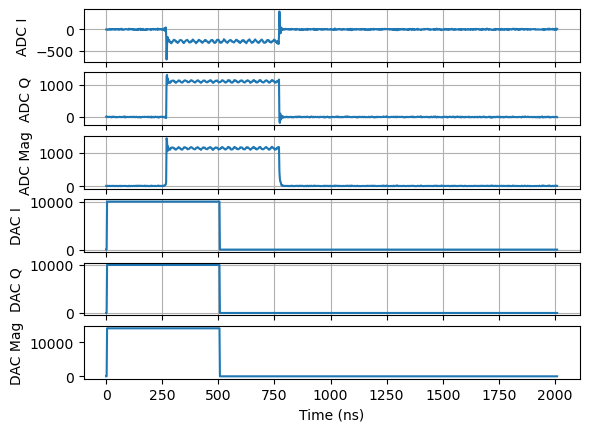

In [4]:
# Set both ADC and DAC to use a 1000 MHz NCO for digital RF mixing
SetAdcNco(ncoFreqMhz=1000.0)
SetDacNco(ncoFreqMhz=1000.0)

# Then trigger then plot waveforms
TriggerThenPlotWavform()

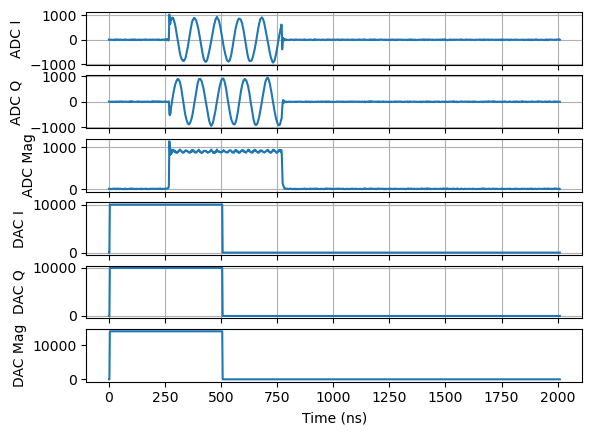

In [5]:
# Set ADC.NCO=1010 MHz & DAC.NCO=1000
SetAdcNco(ncoFreqMhz=1010.0)
SetDacNco(ncoFreqMhz=1000.0)

# Should observe 10 MHz signal on ADC waveform during the pulse
# 5 cycles over the ~500ns, 10 MHz = 1010MHz-1000MHz
TriggerThenPlotWavform()

In [6]:
# Stop the root device
root.stop()